## Definição do *dataset*

O *dataset* utilizado foi criado com o aluno Danilo.

Cada conjunto de dados foi gerado por meio do OpenBCI Ganglion Board, com taxa de amostragem de 200 Hz, utilizando 4 eletrodos.
- Tempo de cada movimento: 10 segundos;
- Tempo de descanso: 5 segundos;
- Sequência de movimentos: (1) mão aberta, (2) mão fechada, (3) pinça com todos os dedos, (4) inclinar palma à esquerda e (5) inclinar palma à direita;

- shape = (4, 20000, 5) => 4 eletrodos, 20000 amostras e 5 movimentos;
- Foi realizado 3 sessões mantendo a mão no movimento indicado até o final de 10 segundos;
- Foi realizado 3 sessões realizando o movimento várias vezes.

### Dependências

In [1]:
import numpy as np
from numpy import genfromtxt
import math
from librosa import stft
from scipy.signal import stft
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy import signal
%matplotlib inline
import matplotlib.pyplot as plt

### Definição das funções de "passa-faixa", "passa-baixa", "passa-alta" e "corta-faixa".

In [2]:
def butter_bandpass(data, lowcut, highcut, fs=200, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)

def butter_lowpass(data, lowcut, fs=200, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='lowpass')
    return signal.filtfilt(b, a, data)

def butter_highpass(data, highcut, fs=200, order=4):
    nyq = fs * 0.5
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='highpass')
    return signal.filtfilt(b, a, data)

def butter_notch(data, cutoff, var=1, fs=200, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data)

In [3]:
# Aplicando ao sinal o filtro "notch", seguido por "lowpass" e "highpass"

def aplica_filtros(data):
    data = np.transpose(data, (0, 2, 1))
    print("Sinal sem filtro:")
    for k in range(data.shape[1]):
        plt.plot(data[3,k,:])
    plt.show()
    
    data_filtered = butter_notch(data, 60)
    data_filtered = butter_highpass(data_filtered, 5)
    data_filtered = butter_lowpass(data_filtered, 50)
    print("Sinal com filtro:")
    for k in range(data_filtered.shape[1]):
        plt.plot(data_filtered[3,k,:])
    plt.show()
    return data_filtered

### Carregando dataset

Shape da matriz: 5 movimentos, 6 tentativas, 4 eletrodos, 2000 amostras

Sinal sem filtro:


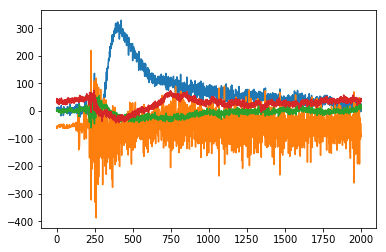

Sinal com filtro:


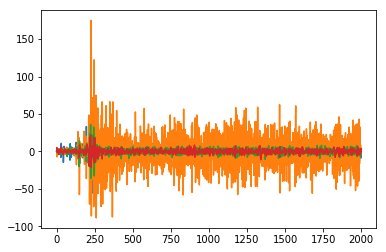

Sinal sem filtro:


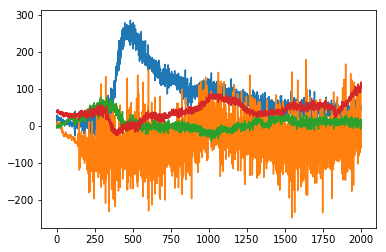

Sinal com filtro:


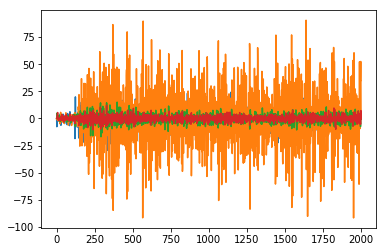

Sinal sem filtro:


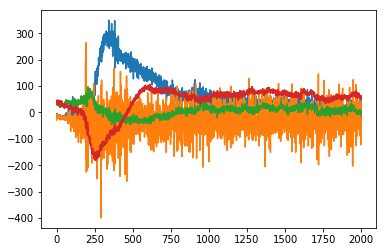

Sinal com filtro:


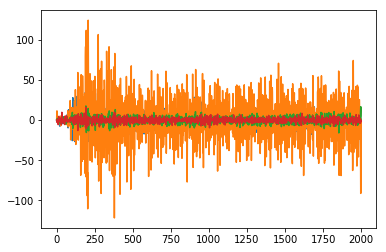

Sinal sem filtro:


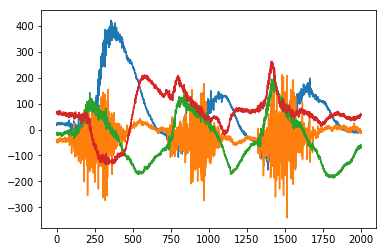

Sinal com filtro:


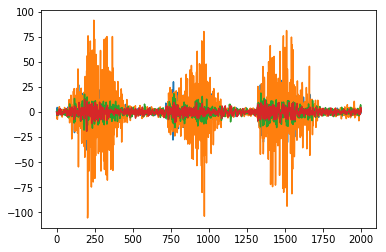

Sinal sem filtro:


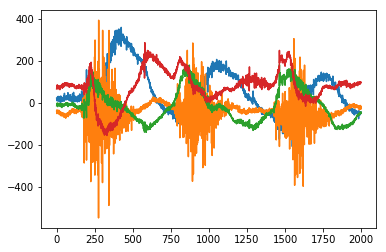

Sinal com filtro:


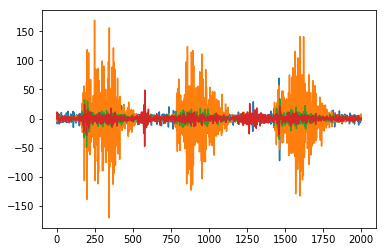

Sinal sem filtro:


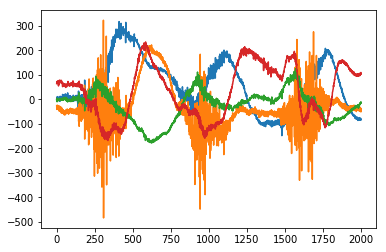

Sinal com filtro:


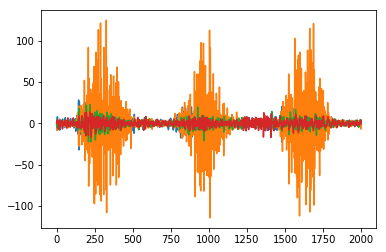

(5, 6, 4, 2000)


In [4]:
# Carregando dados
path = 'emg_data_psd_2019-2/Danilo'
hora = ['201252', '201433', '201601', '201941', '202307', '202431']

lista = list()
j = 0
for i in [1, 1, 1, 2, 2, 2]:
    arq = np.load("{}/{}_EMG_Danilo_02-12-2019_{}.npy".format(path, i, hora[j]))
    arq = aplica_filtros(arq) # Aplicando filtros
    lista.append(arq)
    j += 1

data = np.asarray(lista).transpose(1,0,2,3)
print(data.shape)

### Segmentação dos dados

In [5]:
print(data.shape)
# Definição do salto e do tamanho do segmento (segmento - salto = sobreposição)
salto = 14
segmento = 67
n_win = int((data.shape[-1] - segmento) / salto) + 1
ids = np.arange(n_win) * salto
x = np.array([data[:,:,:,k:(k + segmento)] for k in ids]).transpose(1, 2, 3, 0, 4)
print(x.shape)

# Tirando os 4 últimos segmentos
x = x[:,:,:,0:135,:]
print(x.shape)

(5, 6, 4, 2000)
(5, 6, 4, 139, 67)
(5, 6, 4, 135, 67)


### Extraindo características no domínio do tempo

* `Mean Absolute Value (MAV)`: 
    > $\frac{1}{N}\sum_{i=1}^{N}|x_i|$

In [6]:
print(x.shape)
mav = np.sum(abs(x)/segmento, axis=-1)
print(mav.shape)

(5, 6, 4, 135, 67)
(5, 6, 4, 135)


* `Variance of EMG (VAR)`: 
    > $\frac{1}{N-1}\sum_{i=1}^{N}x_i^2$

In [7]:
print(x.shape)
var = np.sum(np.power(x, 2)/(segmento-1), axis=-1)
print(var.shape)

(5, 6, 4, 135, 67)
(5, 6, 4, 135)


* `Simple Square Integral (SSI)`: 
    > $\sum_{i=1}^{N}|x_i|^2$

In [8]:
print(x.shape)
ssi = np.sum(np.power(abs(x), 2), axis=-1)
print(ssi.shape)

(5, 6, 4, 135, 67)
(5, 6, 4, 135)


* `Root Mean Square (RMS)`: 
    > $\sqrt{\frac{1}{N}\sum_{i=1}^{N}|x_i|^2}$

In [9]:
print(x.shape)
rms = np.sqrt(np.sum((np.power(abs(x), 2))/segmento, axis=-1))
print(rms.shape)

(5, 6, 4, 135, 67)
(5, 6, 4, 135)


### Extraindo características no domínio da frequência

#### Transformação para o domínio da frequência

Aplicando stft no último eixo de data (3), com janela de 1024 e sobreposição de 512.

In [10]:
print(data.shape)
_, _, w = stft(data, fs=200, nperseg=64, noverlap=49)
w = np.swapaxes(w, 3, 4)
print(w.shape)

(5, 6, 4, 2000)
(5, 6, 4, 135, 33)


#### Power Spectrum Density (PSD)

Quadrado do valor absoluto de FFT.

In [11]:
psd = np.power(abs(w), 2)
print(psd.shape)

(5, 6, 4, 135, 33)


* `Frequency Median (FMD)`: 
    > $\frac{1}{2}\sum_{i=1}^{M}PSD$

In [12]:
fmd = np.sum(psd/2, axis=-1)
print(fmd.shape)

(5, 6, 4, 135)


* `Frequency Mean (FMN)`: 
    > $FMN = \frac{\sum_{i=1}^{M}f_i PSD}{\sum_{i=1}^{M}PSD_i}$
    
    > $f_i = \frac{i * SampleRate}{2M}$

In [13]:
sampleRate = 200
M = 33
f = np.array([(i*sampleRate)/(2*M) for i in range(1,M+1)])

fmn = np.divide((np.sum(np.multiply(psd,f), axis = -1)), (np.sum(psd, axis=-1)))

print(fmn.shape)

(5, 6, 4, 135)


#### Criando vetor de características 

In [14]:
features = list()
for feature in (mav, var, ssi, rms, fmd, fmn):
    feature = feature.transpose(0, 1, 3, 2)
    feature = feature.reshape(5 * 6 * 135, 4)
    features.append(feature)

X = np.concatenate(features, axis=-1)
X.shape

(4050, 24)

#### Criando vetor de labels

In [15]:
y = np.array([[str(i)] * int(X.shape[0] / 5) for i in range(5)])
y = y.reshape(y.shape[0] * y.shape[1])
y.shape

(4050,)

#### Classificação

Aplicando classificador SVC e testando acurácia para os diferentes valores de kernel, c e gamma.

In [16]:
# dividindo as porções de dados em treino e teste (70 e 30% respectivamente)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

# o trabalho das diferentes parametrizações ficam a cargo dos alunos
# clf = SVC(gamma='auto')
# clf.fit(X_train, y_train)

# res = clf.predict(X_test)
# tot_hit = sum([1 for i in range(len(res)) if res[i] == y_test[i]])
# print('Acurácia: {:.2f}%'.format(tot_hit / X_test.shape[0] * 100))


for kernel in ['rbf']:#, 'linear']:
    for gamma in [0.001, 0.01, 0.1]:
        for C in [1, 10, 100, 1000]:
            classificador = []
            classificador = SVC(gamma=gamma, C=C, kernel=kernel).fit(X_train, y_train)
            print('acuracia:', (classificador.score(X_test, y_test)) * 100, 'kernel:', kernel, 'gamma:', gamma, 'C:', C)

acuracia: 19.34156378600823 kernel: rbf gamma: 0.001 C: 1
acuracia: 19.4238683127572 kernel: rbf gamma: 0.001 C: 10
acuracia: 19.4238683127572 kernel: rbf gamma: 0.001 C: 100
acuracia: 19.4238683127572 kernel: rbf gamma: 0.001 C: 1000
acuracia: 18.02469135802469 kernel: rbf gamma: 0.01 C: 1
acuracia: 18.02469135802469 kernel: rbf gamma: 0.01 C: 10
acuracia: 18.02469135802469 kernel: rbf gamma: 0.01 C: 100
acuracia: 18.02469135802469 kernel: rbf gamma: 0.01 C: 1000
acuracia: 18.02469135802469 kernel: rbf gamma: 0.1 C: 1
acuracia: 18.02469135802469 kernel: rbf gamma: 0.1 C: 10
acuracia: 18.02469135802469 kernel: rbf gamma: 0.1 C: 100
acuracia: 18.02469135802469 kernel: rbf gamma: 0.1 C: 1000
